In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CustDist_WHCentral = pd.read_csv("CustDist_WHCentral.csv", sep=",", decimal=".")
del CustDist_WHCentral["Distances between Customers and Warehouse"]
CustDist_WHCentral_list = CustDist_WHCentral.values.tolist()

CustDist_WHCorner = pd.read_csv("CustDist_WHCorner.csv", sep=",", decimal=".")
del CustDist_WHCorner["Distances between Customers and Warehouse"]
CustDist_WHCorner_list = CustDist_WHCorner.values.tolist()

CustOrd = pd.read_csv("CustOrd.csv", sep=",", decimal=".")
del CustOrd["Customer"]
CustOrd_list = CustOrd.values.tolist()

In [3]:
#just to test 
import random

#creates the test list
test_list = list(range(1, 51))

#shuffles the list
for i in range(1000):
    index1 = random.randint(0,49)
    index2 = random.randint(0,49)
        
    val1 = test_list[index1]
    test_list[index1] = test_list[index2]
    test_list[index2] = val1

    
print(test_list)

[3, 46, 48, 4, 14, 35, 17, 15, 26, 6, 19, 32, 18, 1, 5, 13, 7, 25, 20, 31, 39, 11, 37, 24, 50, 44, 21, 30, 41, 38, 27, 42, 33, 40, 23, 45, 9, 16, 8, 29, 2, 12, 10, 36, 49, 34, 43, 47, 28, 22]


In [4]:
def evaluatecost(individual):
    total_distance = 0 
    load = 1000 
    
    for i in individual:
        #doesnt have enough load 
        if(load < CustOrd_list[i][0]):
            #last location -> central
            total_distance = total_distance + CustDist_WHCentral_list[0][i-1]
            load = 1000
            
            #central -> next location
            total_distance = total_distance + CustDist_WHCentral_list[0][i]
            load = load - CustOrd_list[i][0]
        
        #last client
        if(i == (len(individual) - 1)):
            #last location -> next location
            total_distance = total_distance + CustDist_WHCentral_list[i][i-1]
            load = load - CustOrd_list[i][0]
            #next location -> warehouse
            total_distance = total_distance + CustDist_WHCentral_list[i][0]
        
        #first client
        if(i == 0):
            #warehouse -> next location
            total_distance = total_distance + CustDist_WHCentral_list[0][i]
            load = load - CustOrd_list[i][0]
        
        #has enough load 
        else: 
            #last location -> next location
            total_distance = total_distance + CustDist_WHCentral_list[i][i-1]
            load = load - CustOrd_list[i][0]
            
    return total_distance,

In [5]:
evaluatecost(test_list)



(2822,)

In [6]:
import random

import random
import numpy as np
from deap import base, creator, tools


def P1(Number_Customers, Population_Size, Number_of_Evaluations, seed):
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    ## permutation setup for individual,
    toolbox.register("indices", \
                     random.sample, \
                     range(Number_Customers), 
                     Number_Customers)

    toolbox.register("individual", \
                     tools.initIterate, \
                     creator.Individual, toolbox.indices)

    ## population setup,
    toolbox.register("population", \
                     tools.initRepeat, \
                     list, toolbox.individual)


    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
    toolbox.register("evaluate", evaluatecost)
    toolbox.register("select", tools.selTournament, tournsize=10)
    
    
    random.seed(seed)

    # create an initial population of 300 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=Population_Size)

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.8, 0.1
    
    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    arr_mean = []
    arr_min = []
    # Begin the evolution
    while g < Number_of_Evaluations/ Population_Size:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)

        arr_mean.append(mean)
        arr_min.append(min(fits))
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    
    x_coordinate = [i+1 for i in range(len(arr_mean))]
    plt.plot(x_coordinate, arr_mean, label = "Average")
    plt.plot(x_coordinate, arr_min, label = "Min")
    plt.title("Min and Average Fitness over generations")
    plt.legend()
    plt.grid()
    plt.figure()

    return 

Start of evolution
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 89 individuals
  Min 2725.0
  Max 2821.0
  Avg 2784.7
  Std 23.425840433192906
-- Generation 2 --
  Evaluated 83 individuals
  Min 2725.0
  Max 2832.0
  Avg 2781.6
  Std 28.820131852588023
-- Generation 3 --
  Evaluated 88 individuals
  Min 2725.0
  Max 2828.0
  Avg 2771.01
  Std 31.110286080297215
-- Generation 4 --
  Evaluated 76 individuals
  Min 2725.0
  Max 2828.0
  Avg 2747.62
  Std 32.2371772958052
-- Generation 5 --
  Evaluated 87 individuals
  Min 2720.0
  Max 2815.0
  Avg 2744.06
  Std 31.78862060549467
-- Generation 6 --
  Evaluated 80 individuals
  Min 2720.0
  Max 2828.0
  Avg 2746.85
  Std 33.77673015554693
-- Generation 7 --
  Evaluated 70 individuals
  Min 2720.0
  Max 2833.0
  Avg 2741.01
  Std 31.240196862351773
-- Generation 8 --
  Evaluated 79 individuals
  Min 2720.0
  Max 2784.0
  Avg 2721.76
  Std 8.743134449333763
-- Generation 9 --
  Evaluated 82 individuals
  Min 2720.0
  Max 2784.0


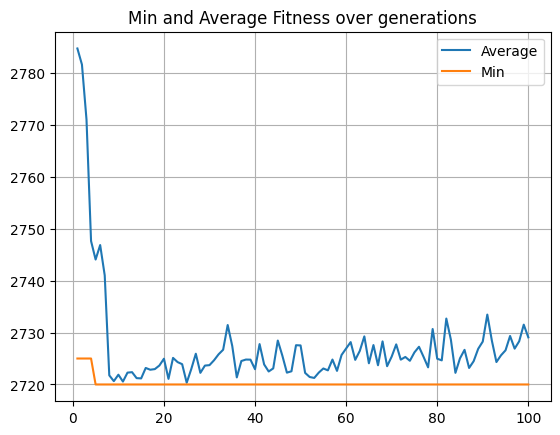

<Figure size 640x480 with 0 Axes>

In [7]:
P1(50, 100, 10000, 50)